# Asexual models

In [ ]:
!time pip install rdkit-pypi==2021.09.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.6/20.6 MB 16.5 MB/s eta 0:00:00

real	0m17.484s
user	0m8.342s
sys	0m1.416s


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
# import seaborn as sn
# import scipy as sp
from rdkit import Chem # A core definition
from rdkit.Chem.Draw import MolsToGridImage # For displaying multiple molecules
from rdkit.Chem.AllChem import * # conformer generation and adding H
from rdkit.Chem.rdMolDescriptors import * # To calculate descriptors
from rdkit.Chem.Draw import IPythonConsole # This displays the molecule in-line
from rdkit.Chem import PandasTools # for pandas dataframe with rdkit
from rdkit.DataStructs.cDataStructs import ConvertToNumpyArray
import pandas.io.formats.style

import random
import tensorflow
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, BatchNormalization, Conv2D, Dropout, Flatten
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier, KerasRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold


In [ ]:
axl= pd.read_csv("M_asexuals_lib_hits_nd_clst_nhts.csv")
axl['Hit'] = axl['Hit'].replace(np.nan, "No")
axl = axl.iloc[: , 1:]
print(axl['Hit'].value_counts())
axl

In [ ]:
# rdkit seems to get stuck at certain parts when converting smiles into mols and
# and gives C++ coverter error. However when I split the dataset at these parts
# this seems to prevent the error.
compounds =[]
df1= axl[:20000]

for _, smiles, hit in df1[["Smiles", "Hit"]].itertuples():
    compounds.append((Chem.MolFromSmiles(smiles),hit))

df2= axl[20001:23766]

for _, smiles, hit in df2[["Smiles", "Hit"]].itertuples():
    compounds.append((Chem.MolFromSmiles(smiles),hit))

df3= axl[23767:25396]

for _, smiles, hit in df3[["Smiles", "Hit"]].itertuples():
    compounds.append((Chem.MolFromSmiles(smiles),hit))


df4= axl[25397:25662]

for _, smiles, hit in df4[["Smiles", "Hit"]].itertuples():
    compounds.append((Chem.MolFromSmiles(smiles),hit))

df5= axl[25663:26912]

for _, smiles, hit in df5[["Smiles", "Hit"]].itertuples():
    compounds.append((Chem.MolFromSmiles(smiles),hit))

df6= axl[26913:28399]

for _, smiles, hit in df6[["Smiles", "Hit"]].itertuples():
    compounds.append((Chem.MolFromSmiles(smiles),hit))

df7= axl[28400:]

for _, smiles, hit in df7[["Smiles", "Hit"]].itertuples():
    compounds.append((Chem.MolFromSmiles(smiles),hit))

len(compounds)

59530

In [ ]:
compounds
dff= pd.DataFrame (compounds, columns = ['mol', 'Hit'])
axl=dff
axl["Target"] = np.where(axl["Hit"]== "Yes", 1,0)
axl["Target"].value_counts()

,mol,Hit
0,"<img data-content=""rdkit/molecule"" src=""data:i...",Yes
1,"<img data-content=""rdkit/molecule"" src=""data:i...",Yes
2,"<img data-content=""rdkit/molecule"" src=""data:i...",Yes
3,"<img data-content=""rdkit/molecule"" src=""data:i...",Yes
4,"<img data-content=""rdkit/molecule"" src=""data:i...",Yes
...,...,...
59525,"<img data-content=""rdkit/molecule"" src=""data:i...",No
59526,"<img data-content=""rdkit/molecule"" src=""data:i...",No
59527,"<img data-content=""rdkit/molecule"" src=""data:i...",No
59528,"<img data-content=""rdkit/molecule"" src=""data:i...",No


# Molecular Morgan Fingerprint (MFP)

In [ ]:
from rdkit.Chem import PandasTools # for pandas dataframe with rdkit


def get_input(mol):
  fp = GetMorganFingerprintAsBitVect(mol, 5, nBits=500) # gets the vector
  arr = np.zeros((0,))
  ConvertToNumpyArray(fp,arr)  # converts the vector to numpy array
  return arr

axl["Input"] = axl["mol"].apply(get_input) # adding the input column to the dataframe
axl["Target"] = np.where(axl["Hit"]== "Yes", 1,0)
axl["Target"].value_counts()
axl

,mol,Hit,Target,Input
0,"<img data-content=""rdkit/molecule"" src=""data:i...",Yes,1,"[0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,"<img data-content=""rdkit/molecule"" src=""data:i...",Yes,1,"[0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ..."
2,"<img data-content=""rdkit/molecule"" src=""data:i...",Yes,1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,"<img data-content=""rdkit/molecule"" src=""data:i...",Yes,1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ..."
4,"<img data-content=""rdkit/molecule"" src=""data:i...",Yes,1,"[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
...,...,...,...,...
59525,"<img data-content=""rdkit/molecule"" src=""data:i...",No,0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ..."
59526,"<img data-content=""rdkit/molecule"" src=""data:i...",No,0,"[1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, ..."
59527,"<img data-content=""rdkit/molecule"" src=""data:i...",No,0,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
59528,"<img data-content=""rdkit/molecule"" src=""data:i...",No,0,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."


In [ ]:
from rdkit import Chem # A core definition
from rdkit.Chem.Draw import MolsToGridImage # For displaying multiple molecules
from rdkit.Chem.AllChem import * # conformer generation and adding H
from rdkit.Chem.rdMolDescriptors import * # To calculate descriptors
from rdkit.Chem.Draw import IPythonConsole # This displays the molecule in-line
from rdkit.Chem import PandasTools # for pandas dataframe with rdkit
from rdkit.DataStructs.cDataStructs import ConvertToNumpyArray
import pandas.io.formats.style
mfp= []
mfp = axl["mol"].apply(get_input) # adding the input column to the dataframe
mfp_list = mfp.tolist()
mfpdf= pd.DataFrame(mfp_list)
df = pd.DataFrame(mfpdf)
df

In [ ]:
from sklearn.model_selection import train_test_split
Xt_train, Xt_test, Yt_train, Yt_test = train_test_split(df, axl["Target"],test_size=0.2, random_state=42)

## Hyperparameter tuning


---



---



In [ ]:
kernels = ['Polynomial', 'RBF', 'Sigmoid','Linear']#A function which returns the corresponding SVC model
def getClassifier(ktype):
    if ktype == 0:
        # Polynomial kernal
        return SVC(kernel='poly', degree=8, gamma="auto",class_weight='balanced', probability=True)
    elif ktype == 1:
        # Radial Basis Function kernal
        return SVC(kernel='rbf', gamma="auto", class_weight='balanced', probability=True)
    elif ktype == 2:
        # Sigmoid kernal
        return SVC(kernel='sigmoid', gamma="auto", class_weight='balanced', probability=True)
    elif ktype == 3:
        # Linear kernal
        return SVC(kernel='linear', gamma="auto", class_weight='balanced', probability=True)

In [ ]:
## https://www.vebuso.com/2020/03/svm-hyperparameter-tuning-using-gridsearchcv/
import pandas as pd
import numpy as np
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import recall_score, precision_recall_curve,precision_score, confusion_matrix, accuracy_score, f1_score, roc_auc_score
import matplotlib.pyplot as plt
%matplotlib inline

for i in range(4):
    # Separate data into test and training sets
    X_train, X_test, y_train, y_test = train_test_split(df, axl["Target"],test_size=0.2, random_state=42)# Train a SVC model using different kernal
    svclassifier = getClassifier(i)
    svclassifier.fit(X_train, y_train)# Make prediction
    y_pred = svclassifier.predict(X_test)# Evaluate our model
    print("Evaluation:", kernels[i], "kernel")
    print(classification_report(y_test,y_pred))

Evaluation: Polynomial kernel
              precision    recall  f1-score   support

           0       0.49      1.00      0.66      5870
           1       0.00      0.00      0.00      6036

    accuracy                           0.49     11906
   macro avg       0.25      0.50      0.33     11906
weighted avg       0.24      0.49      0.33     11906



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Evaluation: RBF kernel
              precision    recall  f1-score   support

           0       0.89      0.93      0.91      5870
           1       0.92      0.88      0.90      6036

    accuracy                           0.90     11906
   macro avg       0.91      0.91      0.90     11906
weighted avg       0.91      0.90      0.90     11906

Evaluation: Sigmoid kernel
              precision    recall  f1-score   support

           0       0.88      0.91      0.89      5870
           1       0.91      0.88      0.89      6036

    accuracy                           0.89     11906
   macro avg       0.89      0.89      0.89     11906
weighted avg       0.89      0.89      0.89     11906



In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.svm import SVC
# defining parameter range
param_grid = {'C': [0.1, 1, 10, 100],
              'gamma': [1, 0.1, 0.01],
              'kernel': ['rbf']}

grid = GridSearchCV(SVC(class_weight='balanced', probability=True), param_grid,cv=KFold(n_splits=3), refit = True, verbose = 3)

# fitting the model for grid search
grid.fit(Xt_train, Yt_train)

In [ ]:
print(grid.best_params_) # Note these parameters (C and gamma) gave the same performance as default parameters but took very long in model building (5+ hours), hence default parameters were chosen

{'C': 1000, 'gamma': 0.01, 'kernel': 'rbf'}


## Training

In [ ]:
######################################################################Penalized_SVM (https://www.analyticsvidhya.com/blog/2020/07/10-techniques-to-deal-with-class-imbalance-in-machine-learning/)

# load library
from sklearn.svm import SVC

# we can add class_weight='balanced' to add panalize mistake
svc_model = SVC(class_weight='balanced', probability=True)

svc_model.fit(Xt_train, Yt_train)

In [ ]:
# Save Model Using joblib
import pandas
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
import joblib

%cd /content/
# save the model to disk
filename = 'asexualsSVCFinalHPT_UMFP_model5005.pkl'
joblib.dump(svc_model, filename)

## Creating Unbalanced Asexual test set

In [ ]:
#Original training set
import pandas as pd
axl= pd.read_csv("M_asexuals_lib_hits_nd_clst_nhts.csv")
axl['Hit'] = axl['Hit'].replace(np.nan, "No")
axl = axl.iloc[: , 1:]
print(axl['Hit'].value_counts())
axl

In [ ]:
axl["Target"] = np.where(axl["Hit"]== "Yes", 1,0)
axl["Target"].value_counts()

1    30393
0    29143
Name: Target, dtype: int64

In [ ]:
compounds =[]
df1= axl[:20000]

for _, smiles, hit in df1[["Smiles", "Hit"]].itertuples():
    compounds.append((Chem.MolFromSmiles(smiles),hit, smiles))

df2= axl[20001:23766]

for _, smiles, hit in df2[["Smiles", "Hit"]].itertuples():
    compounds.append((Chem.MolFromSmiles(smiles),hit, smiles))
df3= axl[23767:25396]

for _, smiles, hit in df3[["Smiles", "Hit"]].itertuples():
    compounds.append((Chem.MolFromSmiles(smiles),hit, smiles))


df4= axl[25397:25662]

for _, smiles, hit in df4[["Smiles", "Hit"]].itertuples():
    compounds.append((Chem.MolFromSmiles(smiles),hit, smiles))

df5= axl[25663:26912]

for _, smiles, hit in df5[["Smiles", "Hit"]].itertuples():
    compounds.append((Chem.MolFromSmiles(smiles),hit, smiles))

df6= axl[26913:28399]

for _, smiles, hit in df6[["Smiles", "Hit"]].itertuples():
    compounds.append((Chem.MolFromSmiles(smiles),hit, smiles))
df7= axl[28400:]

for _, smiles, hit in df7[["Smiles", "Hit"]].itertuples():
    compounds.append((Chem.MolFromSmiles(smiles),hit, smiles))

len(compounds)

59530

In [ ]:
compounds
dff= pd.DataFrame (compounds, columns = ['mol', 'Hit', "Smiles"])
axl=dff
from rdkit.Chem import PandasTools # for pandas dataframe with rdkit


def get_input(mol):
  fp = GetMorganFingerprintAsBitVect(mol, 5, nBits=500) # gets the vector
  arr = np.zeros((0,))
  ConvertToNumpyArray(fp,arr)  # converts the vector to numpy array
  return arr

axl["Input"] = axl["mol"].apply(get_input) # adding the input column to the dataframe
axl["Target"] = np.where(axl["Hit"]== "Yes", 1,0)
axl["Target"].value_counts()
axl

In [ ]:
mfp= []
mfp = axl["mol"].apply(get_input) # adding the input column to the dataframe
mfp_list = mfp.tolist()
mfpdf= pd.DataFrame(mfp_list)
df = pd.DataFrame(mfpdf)
df["Smiles"]= axl["Smiles"]
df

<class 'pandas.core.series.Series'>


0        [0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
1        [0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, ...
2        [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
3        [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...
4        [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
                               ...                        
59525    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...
59526    [1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 0.0, ...
59527    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
59528    [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
59529    [0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
Name: mol, Length: 59530, dtype: object

In [ ]:
from sklearn.model_selection import train_test_split
Xt_train1, Xt_test1, Yt_train1, Yt_test1 = train_test_split(df, axl["Target"],test_size=0.2, random_state=42)

### Unbalanced test set

In [ ]:
##Select those not in train set (Note this dataset does not contain the complete set of hits so need to add those)
sxl= pd.read_csv("/content/Merged_asexual_libraries_hits and nonhits_nd.csv")
as_nhts= sxl[sxl["Hit"]== "No"]
print(len(as_nhts))

df_smiles = as_nhts[['Smiles',"Compound Key", "Hit"]]

,Unnamed: 0,Smiles,CHEMBLID,Hit,Compound Key
0,0,O=C(OCc1ccccc1)N1CC[C@H]2CC(CO)O[C@@H]2C1,CHEMBL3470688,No,DDD01082494
1,1,Cc1cc(C(=O)N(C)C)nc(C2(C)CCCN2c2ccccc2)n1,CHEMBL3447812,No,DDD01058126
2,2,CN(C)c1nc2c(c(N3CCC(O)CC3)n1)CN(CC1CCNC1)CC2,CHEMBL3486462,No,DDD01257825
3,3,O=C1CCC(C(=O)Nc2cnn(-c3ccccc3Br)c2)N1,CHEMBL3467813,No,DDD01078886
4,4,O=C(CCNc1ccccc1)NC1CCN(C(=O)C2CCCCC2)CC1,CHEMBL3452692,No,DDD01063562
...,...,...,...,...,...
122566,122566,CC(/C=C/C(=O)NO)=C\[C@@H](C)C(=O)c1ccc(N(C)C)cc1,CHEMBL99,Yes,GNF-Pf-1011
122567,122567,O=[N+]([O-])c1cc([N+](=O)[O-])c2cccnc2c1Nc1ccc...,CHEMBL603032,No,GNF-Pf-1014
122568,122568,COc1ccc2c(c1)N(C(=O)CSc1nc3ccccc3o1)C(C)(C)c1s...,CHEMBL585033,Yes,GNF-Pf-4623
122569,122569,CCN1/C(=C/c2cccc[n+]2C)Sc2ccccc21,CHEMBL583805,Yes,GNF-Pf-1023


In [ ]:
## Compound
compounds = []
df1 = df_smiles. iloc [:1300]
df2 = df_smiles. iloc [1301:2600]
df3 = df_smiles. iloc [2601:3900]
df4 = df_smiles. iloc [3901:4300] #note error observed between compounds 4301-4310
df5 = df_smiles. iloc [4310:4600]

for _, compound_key, smiles in df1[["Hit", "Smiles"]].itertuples():
    compounds.append((Chem.MolFromSmiles(smiles), compound_key, smiles))

for _, compound_key, smiles  in df2[["Hit", "Smiles"]].itertuples():
    compounds.append((Chem.MolFromSmiles(smiles), compound_key, smiles))

for _, compound_key, smiles in df3[["Hit", "Smiles"]].itertuples():
    compounds.append((Chem.MolFromSmiles(smiles), compound_key, smiles))

for _, compound_key, smiles in df4[["Hit", "Smiles"]].itertuples():
    compounds.append((Chem.MolFromSmiles(smiles), compound_key, smiles))

for _, compound_key, smiles in df5[["Hit", "Smiles"]].itertuples():
    compounds.append((Chem.MolFromSmiles(smiles), compound_key , smiles))

df6 = df_smiles. iloc [4650:5600]
for _, compound_key, smiles in df6[["Hit", "Smiles"]].itertuples():
    compounds.append((Chem.MolFromSmiles(smiles), compound_key , smiles))

df7 = df_smiles. iloc [5700:6150]
for _, compound_key, smiles in df7[["Hit", "Smiles"]].itertuples():
    compounds.append((Chem.MolFromSmiles(smiles), compound_key , smiles))

df8 = df_smiles. iloc [6180:7970]
for _, compound_key, smiles  in df8[["Hit", "Smiles"]].itertuples():
    compounds.append((Chem.MolFromSmiles(smiles), compound_key, smiles))

df9 = df_smiles. iloc [8000:10730]
for _, compound_key, smiles  in df9[["Hit", "Smiles"]].itertuples():
    compounds.append((Chem.MolFromSmiles(smiles), compound_key, smiles))

df10 = df_smiles. iloc [10740:11410]
for _, compound_key, smiles in df10[["Hit", "Smiles"]].itertuples():
    compounds.append((Chem.MolFromSmiles(smiles), compound_key, smiles))

df11 = df_smiles. iloc [11420:14010]
for _, compound_key, smiles in df11[["Hit", "Smiles"]].itertuples():
    compounds.append((Chem.MolFromSmiles(smiles), compound_key, smiles))

df12 = df_smiles. iloc [14020:14580]
for _, compound_key, smiles in df12[["Hit", "Smiles"]].itertuples():
    compounds.append((Chem.MolFromSmiles(smiles), compound_key, smiles))

df13 = df_smiles. iloc [14590:15794]
for _, compound_key, smiles  in df13[["Hit", "Smiles"]].itertuples():
    compounds.append((Chem.MolFromSmiles(smiles), compound_key, smiles))

df14 = df_smiles. iloc [15795:18061]
for _, compound_key, smiles  in df14[["Hit", "Smiles"]].itertuples():
    compounds.append((Chem.MolFromSmiles(smiles), compound_key, smiles))

df15 = df_smiles. iloc [18062:20531]
for _, compound_key, smiles  in df15[["Hit", "Smiles"]].itertuples():
    compounds.append((Chem.MolFromSmiles(smiles), compound_key, smiles))

df16 = df_smiles. iloc [20532:20964]
for _, compound_key, smiles in df16[["Hit", "Smiles"]].itertuples():
    compounds.append((Chem.MolFromSmiles(smiles), compound_key, smiles))

df17 = df_smiles. iloc [20966:22471]
for _, compound_key, smiles in df17[["Hit", "Smiles"]].itertuples():
    compounds.append((Chem.MolFromSmiles(smiles), compound_key, smiles))

df18 = df_smiles. iloc [22473:25150]
for _, compound_key, smiles in df18[["Hit", "Smiles"]].itertuples():
    compounds.append((Chem.MolFromSmiles(smiles), compound_key, smiles))

df19 = df_smiles. iloc [25153:25549]
for _, compound_key, smiles  in df19[["Hit", "Smiles"]].itertuples():
    compounds.append((Chem.MolFromSmiles(smiles), compound_key, smiles))

df20= df_smiles. iloc [25551:28743]
for _, compound_key, smiles in df20[["Hit", "Smiles"]].itertuples():
    compounds.append((Chem.MolFromSmiles(smiles), compound_key, smiles))

df21= df_smiles. iloc [28755:30045]
for _, compound_key, smiles  in df21[["Hit", "Smiles"]].itertuples():
    compounds.append((Chem.MolFromSmiles(smiles), compound_key, smiles))

df22= df_smiles. iloc [30047:30857]
for _, compound_key, smiles  in df22[["Hit", "Smiles"]].itertuples():
    compounds.append((Chem.MolFromSmiles(smiles), compound_key, smiles))

df23= df_smiles. iloc [30859:31442]
for _, compound_key, smiles  in df23[["Hit", "Smiles"]].itertuples():
    compounds.append((Chem.MolFromSmiles(smiles), compound_key, smiles))

df24= df_smiles. iloc [31444:31831]
for _, compound_key, smiles in df24[["Hit", "Smiles"]].itertuples():
    compounds.append((Chem.MolFromSmiles(smiles), compound_key, smiles))

df25= df_smiles. iloc [31833:33515]
for _, compound_key, smiles  in df25[["Hit", "Smiles"]].itertuples():
    compounds.append((Chem.MolFromSmiles(smiles), compound_key, smiles))

df26= df_smiles. iloc [33517:33577]
for _, compound_key, smiles  in df26[["Hit", "Smiles"]].itertuples():
    compounds.append((Chem.MolFromSmiles(smiles), compound_key, smiles))

df27= df_smiles. iloc [33579:35623]
for _, compound_key, smiles in df27[["Hit", "Smiles"]].itertuples():
    compounds.append((Chem.MolFromSmiles(smiles), compound_key, smiles))

df28= df_smiles. iloc [35625:36239]
for _, compound_key, smiles  in df28[["Hit", "Smiles"]].itertuples():
    compounds.append((Chem.MolFromSmiles(smiles), compound_key, smiles))

df29= df_smiles. iloc [36240:38411]
for _, compound_key, smiles in df29[["Hit", "Smiles"]].itertuples():
    compounds.append((Chem.MolFromSmiles(smiles), compound_key, smiles))

df30= df_smiles. iloc [38413:38536]
for _, compound_key, smiles in df30[["Hit", "Smiles"]].itertuples():
    compounds.append((Chem.MolFromSmiles(smiles), compound_key, smiles))

df31= df_smiles. iloc [38538:39460]
for _, compound_key, smiles in df31[["Hit", "Smiles"]].itertuples():
    compounds.append((Chem.MolFromSmiles(smiles), compound_key, smiles))

df32= df_smiles. iloc [39462:39880]
for _, compound_key, smiles in df32[["Hit", "Smiles"]].itertuples():
    compounds.append((Chem.MolFromSmiles(smiles), compound_key, smiles))

df33= df_smiles. iloc [39882:44468]
for _, compound_key, smiles  in df33[["Hit", "Smiles"]].itertuples():
    compounds.append((Chem.MolFromSmiles(smiles), compound_key, smiles))

df34= df_smiles. iloc [44479:45910]
for _, compound_key, smiles  in df34[["Hit", "Smiles"]].itertuples():
    compounds.append((Chem.MolFromSmiles(smiles), compound_key, smiles))

df35= df_smiles. iloc [45912:50308]
for _, compound_key, smiles in df35[["Hit", "Smiles"]].itertuples():
    compounds.append((Chem.MolFromSmiles(smiles), compound_key, smiles))

df36= df_smiles. iloc [50310:50644]
for _, compound_key, smiles in df36[["Hit", "Smiles"]].itertuples():
    compounds.append((Chem.MolFromSmiles(smiles), compound_key, smiles))

df37= df_smiles. iloc [50646:50847]
for _, compound_key, smiles in df37[["Hit", "Smiles"]].itertuples():
    compounds.append((Chem.MolFromSmiles(smiles), compound_key, smiles))

df38= df_smiles. iloc [50849:51016]
for _, compound_key, smiles  in df38[["Hit", "Smiles"]].itertuples():
    compounds.append((Chem.MolFromSmiles(smiles), compound_key, smiles))

df39= df_smiles. iloc [51018:52255]
for _, compound_key, smiles  in df39[["Hit", "Smiles"]].itertuples():
    compounds.append((Chem.MolFromSmiles(smiles), compound_key, smiles))

df40= df_smiles. iloc [52257:52515]
for _, compound_key, smiles  in df40[["Hit", "Smiles"]].itertuples():
    compounds.append((Chem.MolFromSmiles(smiles), compound_key, smiles))

df41= df_smiles. iloc [52517:54570]
for _, compound_key, smiles in df41[["Hit", "Smiles"]].itertuples():
    compounds.append((Chem.MolFromSmiles(smiles), compound_key, smiles))

df42= df_smiles. iloc [54572:56375]
for _, compound_key, smiles in df42[["Hit", "Smiles"]].itertuples():
    compounds.append((Chem.MolFromSmiles(smiles), compound_key, smiles))

df43= df_smiles. iloc [56377:57950]
for _, compound_key, smiles  in df43[["Hit", "Smiles"]].itertuples():
    compounds.append((Chem.MolFromSmiles(smiles), compound_key, smiles))

df44= df_smiles. iloc [57952:60363]
for _, compound_key, smiles  in df44[["Hit", "Smiles"]].itertuples():
    compounds.append((Chem.MolFromSmiles(smiles), compound_key, smiles))

df45= df_smiles. iloc [60365:61892]
for _, compound_key, smiles in df45[["Hit", "Smiles"]].itertuples():
    compounds.append((Chem.MolFromSmiles(smiles), compound_key, smiles))

df46= df_smiles. iloc [61894:86486]
for _, compound_key, smiles in df46[["Hit", "Smiles"]].itertuples():
    compounds.append((Chem.MolFromSmiles(smiles), compound_key, smiles))

df47= df_smiles. iloc [86488:87067]
for _, compound_key, smiles in df47[["Hit", "Smiles"]].itertuples():
    compounds.append((Chem.MolFromSmiles(smiles), compound_key, smiles))

df48= df_smiles. iloc [87069:89383]
for _, compound_key, smiles  in df48[["Hit", "Smiles"]].itertuples():
    compounds.append((Chem.MolFromSmiles(smiles), compound_key, smiles))

df49= df_smiles. iloc [89385:90154]
for _, compound_key, smiles in df49[["Hit", "Smiles"]].itertuples():
    compounds.append((Chem.MolFromSmiles(smiles), compound_key, smiles))

df50= df_smiles. iloc [90156:90354]
for _, compound_key, smiles in df50[["Hit", "Smiles"]].itertuples():
    compounds.append((Chem.MolFromSmiles(smiles), compound_key, smiles))

df51= df_smiles. iloc [90356:90609]
for _, compound_key, smiles  in df51[["Hit", "Smiles"]].itertuples():
    compounds.append((Chem.MolFromSmiles(smiles), compound_key, smiles))

df52= df_smiles. iloc [90611:90746]
for _, compound_key, smiles in df52[["Hit", "Smiles"]].itertuples():
    compounds.append((Chem.MolFromSmiles(smiles), compound_key, smiles))

df53= df_smiles. iloc [90748:92006]
for _, compound_key, smiles  in df53[["Hit", "Smiles"]].itertuples():
    compounds.append((Chem.MolFromSmiles(smiles), compound_key, smiles))

df54= df_smiles. iloc [92008:]
for _, compound_key, smiles  in df54[["Hit", "Smiles"]].itertuples():
    compounds.append((Chem.MolFromSmiles(smiles), compound_key, smiles))

len(compounds)

91817

In [ ]:
compounds
dff= pd.DataFrame (compounds, columns = ['mol', 'Hit', "Smiles"])
sxl=dff
sxl

,mol,Hit,Smiles
0,<rdkit.Chem.rdchem.Mol object at 0x7f1beb8066c0>,No,O=C(OCc1ccccc1)N1CC[C@H]2CC(CO)O[C@@H]2C1
1,<rdkit.Chem.rdchem.Mol object at 0x7f1beb806340>,No,Cc1cc(C(=O)N(C)C)nc(C2(C)CCCN2c2ccccc2)n1
2,<rdkit.Chem.rdchem.Mol object at 0x7f1beb806110>,No,CN(C)c1nc2c(c(N3CCC(O)CC3)n1)CN(CC1CCNC1)CC2
3,<rdkit.Chem.rdchem.Mol object at 0x7f1beb806650>,No,O=C1CCC(C(=O)Nc2cnn(-c3ccccc3Br)c2)N1
4,<rdkit.Chem.rdchem.Mol object at 0x7f1beb806490>,No,O=C(CCNc1ccccc1)NC1CCN(C(=O)C2CCCCC2)CC1
...,...,...,...
91812,<rdkit.Chem.rdchem.Mol object at 0x7f1c21429230>,No,O=C(CNCCc1ccccc1)NC(c1ccccc1)c1ccccc1.O=CO.O=CO
91813,<rdkit.Chem.rdchem.Mol object at 0x7f1c214292a0>,No,Cc1ccc(COc2ccc3c(C#N)c4ccccn4c3c2)cc1
91814,<rdkit.Chem.rdchem.Mol object at 0x7f1c21429310>,No,O=C(CN1CCN(S(=O)(=O)c2cccc([N+](=O)[O-])c2)CC1...
91815,<rdkit.Chem.rdchem.Mol object at 0x7f1c21429380>,No,CC(C)N(CC(=O)Nc1cc(C(C)(C)C)nn1-c1ccc(Cl)c(Cl)...


In [ ]:
import pandas as pd
# Add complete set of hits
axl= pd.read_csv("M_asexuals_lib_hits_nd_clst_nhts.csv")
axl['Hit'] = axl['Hit'].replace(np.nan, "No")
axl = axl.iloc[: , 1:]
print(axl['Hit'].value_counts())
axl

/content/drive/MyDrive/PhD/PTS_datasets
Yes    30393
No     29143
Name: Hit, dtype: int64


,Smiles,Hit
0,Cc1cccnc1CN1CC[C@H](Oc2cccc(F)c2)[C@@](C)(O)C1,Yes
1,CC(C)(C)C(=O)N1C[C@H](c2ccsc2)[C@H]2CN(C3CCCCC...,Yes
2,CC(C)N(CCNC(=O)c1[nH]nc2ccc(I)cc12)C(C)C,Yes
3,CC(Nc1nc(-c2ccncc2)nc2c1CCNC2)c1ccccc1,Yes
4,CC(C)C[C@H](N)COc1cccc(F)c1Oc1cccc(Cl)c1,Yes
...,...,...
59531,O=C1CC[C@H]2[C@H](CCN2C(=O)C2CCOC2)N1Cc1ccncc1,No
59532,Cc1cc(Nc2ccc(F)cn2)cc(C2CCN(Cc3ncc[nH]3)C2)n1,No
59533,O=C(CCNc1ccccc1)NC1CCN(C(=O)C2CCCCC2)CC1,No
59534,CN(C)c1nc2c(c(N3CCC(O)CC3)n1)CN(CC1CCNC1)CC2,No


In [ ]:
compounds =[]
df1= axl[:20000]

for _, smiles, hit in df1[["Smiles", "Hit"]].itertuples():
    compounds.append((Chem.MolFromSmiles(smiles), hit, smiles))

df2= axl[20001:23766]

for _, smiles, hit in df2[["Smiles", "Hit"]].itertuples():
    compounds.append((Chem.MolFromSmiles(smiles), hit, smiles))

df3= axl[23767:25396]

for _, smiles, hit in df3[["Smiles", "Hit"]].itertuples():
    compounds.append((Chem.MolFromSmiles(smiles), hit, smiles))


df4= axl[25397:25662]

for _, smiles, hit in df4[["Smiles", "Hit"]].itertuples():
    compounds.append((Chem.MolFromSmiles(smiles), hit, smiles))

df5= axl[25663:26912]

for _, smiles, hit in df5[["Smiles", "Hit"]].itertuples():
    compounds.append((Chem.MolFromSmiles(smiles), hit, smiles))

df6= axl[26913:28399]

for _, smiles, hit in df6[["Smiles", "Hit"]].itertuples():
    compounds.append((Chem.MolFromSmiles(smiles), hit, smiles))

df7= axl[28400:]

for _, smiles, hit in df7[["Smiles", "Hit"]].itertuples():
    compounds.append((Chem.MolFromSmiles(smiles), hit, smiles))

len(compounds)

59530

In [ ]:
#Append two dataframes (one containing complete inactive compound set and the other containing
# complete active compound set)
compounds
dff= pd.DataFrame (compounds, columns = ['mol', 'Hit', "Smiles"])
axl2=dff
as_ht= axl2[axl2["Hit"]== "Yes"]
axl= sxl.append(as_ht)
axl = axl.reset_index(drop=True)


In [ ]:
# Remove SMILES that are in the training set for model training
df3 = axl.loc[~axl['Smiles'].isin(Xt_train1['Smiles'])].copy()
# shuffle the DataFrame rows
df3 = df3.sample(frac = 1)
axl=df3
axl

<ipython-input-28-71be01537f27>:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  axl= sxl.append(as_ht)


,mol,Hit,Smiles
0,<rdkit.Chem.rdchem.Mol object at 0x7f1beb8066c0>,No,O=C(OCc1ccccc1)N1CC[C@H]2CC(CO)O[C@@H]2C1
1,<rdkit.Chem.rdchem.Mol object at 0x7f1beb806340>,No,Cc1cc(C(=O)N(C)C)nc(C2(C)CCCN2c2ccccc2)n1
2,<rdkit.Chem.rdchem.Mol object at 0x7f1beb806110>,No,CN(C)c1nc2c(c(N3CCC(O)CC3)n1)CN(CC1CCNC1)CC2
3,<rdkit.Chem.rdchem.Mol object at 0x7f1beb806650>,No,O=C1CCC(C(=O)Nc2cnn(-c3ccccc3Br)c2)N1
4,<rdkit.Chem.rdchem.Mol object at 0x7f1beb806490>,No,O=C(CCNc1ccccc1)NC1CCN(C(=O)C2CCCCC2)CC1
...,...,...,...
122199,<rdkit.Chem.rdchem.Mol object at 0x7f1c211f1e00>,Yes,COc1ccc(C(C)=NNc2nnc(C)c(O)n2)cc1
122200,<rdkit.Chem.rdchem.Mol object at 0x7f1c211f1e70>,Yes,CC(/C=C/C(=O)NO)=C\[C@@H](C)C(=O)c1ccc(N(C)C)cc1
122201,<rdkit.Chem.rdchem.Mol object at 0x7f1c211f1ee0>,Yes,COc1ccc2c(c1)N(C(=O)CSc1nc3ccccc3o1)C(C)(C)c1s...
122202,<rdkit.Chem.rdchem.Mol object at 0x7f1c211f1f50>,Yes,CCN1/C(=C/c2cccc[n+]2C)Sc2ccccc21


In [ ]:
## Convert test set mols into Mfp
from rdkit.Chem import PandasTools # for pandas dataframe with rdkit
axl["Hit"].value_counts()
def get_input(mol):
  fp = GetMorganFingerprintAsBitVect(mol, 5, nBits=500) # gets the vector
  arr = np.zeros((0,))
  ConvertToNumpyArray(fp,arr)  # converts the vector to numpy array
  return arr

#axl["Input"] = axl["mol"].apply(get_input) # adding the input column to the dataframe
axl["Target"] = np.where(axl["Hit"]== "Yes", 1,0)
axl["Target"].value_counts()
axl

,mol,Hit,Smiles,Target
32262,<rdkit.Chem.rdchem.Mol object at 0x7f1c21ddcba0>,No,CCS(=O)(=O)N1CCC2(CC(=O)N(c3cccc(C)c3)C2)C1,0
22661,<rdkit.Chem.rdchem.Mol object at 0x7f1c23a3f610>,No,Cc1cc(C(=O)CN2C(=O)c3ccccc3CS2(=O)=O)c(C)[nH]1,0
28881,<rdkit.Chem.rdchem.Mol object at 0x7f1c21f3b300>,No,CCn1cc(CNC2CCN(c3cccc(Cl)c3)C2)cn1,0
26053,<rdkit.Chem.rdchem.Mol object at 0x7f1c21ec1310>,No,COc1cc(N2C[C@@H]3COC[C@]3(COCc3ccccn3)C2)ncn1,0
24909,<rdkit.Chem.rdchem.Mol object at 0x7f1c21e957e0>,No,COCc1nc(C(=O)N2CCN(c3nccc(OC)n3)CC2)cs1,0
...,...,...,...,...
82363,<rdkit.Chem.rdchem.Mol object at 0x7f1c21683df0>,No,CCCCNc1c(C(=O)OCC)c(C)nc2c1[nH]c1ccccc12,0
59195,<rdkit.Chem.rdchem.Mol object at 0x7f1c21a80b30>,No,COc1ccc(-c2c[nH]c(C3CC(=O)N(CC(C)C)C3)n2)cc1,0
62561,<rdkit.Chem.rdchem.Mol object at 0x7f1c218a9af0>,No,CN1CCN(C2CCN(CCOc3cccc(Cl)c3)CC2)C1=O,0
18045,<rdkit.Chem.rdchem.Mol object at 0x7f1c23bf86d0>,No,Cc1nc(CCNC(=O)NCC(c2ccco2)N(C)C)cs1,0


In [ ]:
mfp= []
mfp = axl["mol"].apply(get_input) # adding the input column to the dataframe
mfp_list = mfp.tolist()
mfpdf= pd.DataFrame(mfp_list)
df = pd.DataFrame(mfpdf)
Xt_test = df
Yt_test= axl["Target"]

0    58241
1     2788
Name: Target, dtype: int64


# SVC

In [ ]:
import pandas
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
import joblib

In [ ]:

svc_model = joblib.load('/content/drive/MyDrive/PhD/Penalized_SVM_MFP/asexualsSVCFinalHPT_UMFP_model5005.pkl')

In [ ]:
######################################################################Penalized_SVM (https://www.analyticsvidhya.com/blog/2020/07/10-techniques-to-deal-with-class-imbalance-in-machine-learning/)

# load library
from sklearn.svm import SVC

svc_predict = svc_model.predict(Xt_test)# check performance


In [ ]:
from sklearn.metrics import recall_score, precision_recall_curve,precision_score, confusion_matrix, accuracy_score, f1_score
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(Yt_test,svc_predict)
print('Accuracy: %f' % accuracy)
recall= recall_score(Yt_test,svc_predict)
print("Recall %f" % recall)
precision= precision_score(Yt_test,svc_predict)
print("precision %f" % precision)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(Yt_test,svc_predict)
print('F1 score: %f' % f1)
from sklearn.metrics import recall_score, precision_recall_curve,precision_score, confusion_matrix, accuracy_score, f1_score, roc_auc_score
print('ROCAUC score:',roc_auc_score(Yt_test, svc_predict))
print('Accuracy score:',accuracy_score(Yt_test, svc_predict))
print('F1 score:',f1_score(Yt_test, svc_predict))
from sklearn.metrics import recall_score, precision_recall_curve,precision_score, confusion_matrix, accuracy_score, f1_score, roc_auc_score, cohen_kappa_score
# kappa
kappa = cohen_kappa_score(Yt_test, svc_predict)
print('Cohens kappa: %f' % kappa)
# ROC AUC
auc = roc_auc_score(Yt_test, svc_predict)
print('ROC AUC: %f' % auc)
# confusion matrix
matrix = confusion_matrix(Yt_test, svc_predict)
print(matrix)
cm= confusion_matrix(Yt_test,svc_predict)
cm

Accuracy: 0.853234
Recall 0.898852
precision 0.224130
F1 score: 0.358794
ROCAUC score: 0.8749510857238748
Accuracy score: 0.8532337085647806
F1 score: 0.35879447347698473
Cohens kappa: 0.308203
ROC AUC: 0.874951
[[49566  8675]
 [  282  2506]]


array([[49566,  8675],
       [  282,  2506]])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

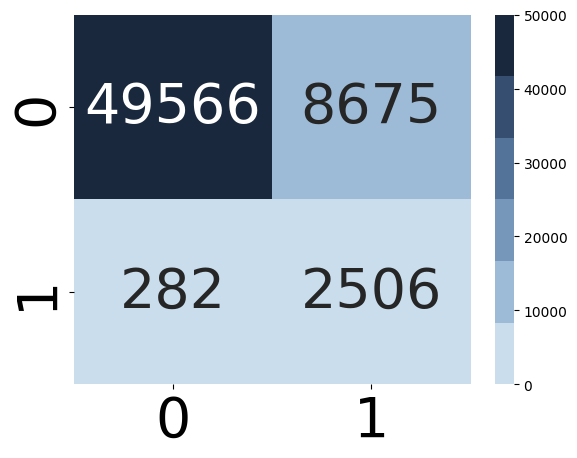

In [ ]:
import seaborn as sns
from sklearn.metrics import recall_score, precision_recall_curve,precision_score, confusion_matrix, accuracy_score, f1_score
cm=[[49566 , 8675],
 [  282 , 2506]]
fig, ax = plt.subplots()
ax.tick_params(labelsize=40)
#ax.legend(markerscale=15)
sns.heatmap(cm, cmap=sns.cubehelix_palette(start=-.19,rot=-0.05), annot=True,annot_kws={"size": 40}, fmt='d',vmin=0, vmax=50000)# font size
plt.savefig('ABS_SVC_UB_testMat.png',dpi=300, bbox_inches='tight')
from google.colab import files
files.download("ABS_SVC_UB_testMat.png")

In [ ]:
print(f"Test Set: {len(Xt_test)}")
print(Yt_test.value_counts())
print(matrix)

Test Set: 61029
0    58241
1     2788
Name: Target, dtype: int64
[[49566  8675]
 [  282  2506]]


# Dual active models

In [ ]:
!time pip install rdkit-pypi==2021.09.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.6/20.6 MB 29.2 MB/s eta 0:00:00

real	0m14.603s
user	0m8.286s
sys	0m0.924s


In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from rdkit import Chem # A core definition
from rdkit.Chem.Draw import MolsToGridImage # For displaying multiple molecules
from rdkit.Chem.AllChem import * # conformer generation and adding H
from rdkit.Chem.rdMolDescriptors import * # To calculate descriptors
from rdkit.Chem.Draw import IPythonConsole # This displays the molecule in-line
from rdkit.Chem import PandasTools # for pandas dataframe with rdkit
from rdkit.DataStructs.cDataStructs import ConvertToNumpyArray
import pandas.io.formats.style
import random
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold

In [ ]:
############################################Sexual data
import pandas as pd
sxl= pd.read_csv("M_sexual_LibrariesC_hits_nd_2ndclst_nhits.csv")
sxl['S_Hit'] = sxl['S_Hit'].replace(np.nan, "No")
sxl = sxl.iloc[: , 1:]
print(sxl['S_Hit'].value_counts())
sxl["Target"] = np.where(sxl["S_Hit"]== "Yes", 1,0)
sxl["Target"].value_counts()

# Molecular Morgan Fingerprint (MFP)

,Smiles,S_Hit,Target,ROMol,Input
0,NC(=O)c1cccc2nc([C@H]3CCN(Cc4ccccn4)C3)[nH]c12,Yes,1,,"[1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,Fc1ccc2[nH]c(C3CCCN3Cc3c[nH]cn3)nc2c1,Yes,1,,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,COc1c(C)cnc(CN(C)C2CCCCC2)c1C,Yes,1,,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,Cc1cccc(CN2CCCC2c2cccc(Nc3nccs3)n2)c1,Yes,1,,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ..."
4,CCSCCNc1nc(-c2ccccn2)nc2c1c(C)nn2C,Yes,1,,"[1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ..."
...,...,...,...,...,...
9886,Cc1nc(C)n(C2CCCN(C(=O)c3ncoc3C(C)C)C2)n1,No,0,,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, ..."
9887,COCCN1CCN(Cc2c(C)noc2C)Cc2ccc(C)nc21,No,0,,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ..."
9888,CCc1ncnc2c1CCN(Cc1ccc3c(c1)OCO3)CC2,No,0,,"[1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ..."
9889,CCC1CN(CC(=O)NCCN2CCCCCC2)c2ccccc2S1,No,0,,"[0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, ..."

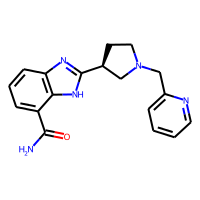
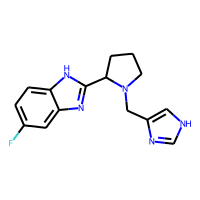
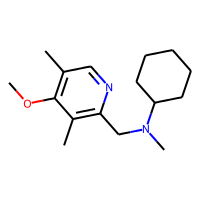
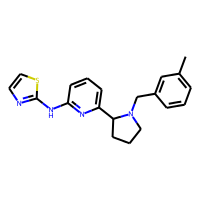
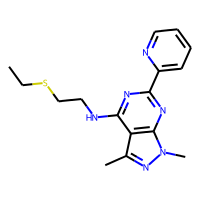
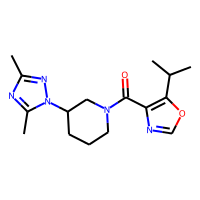
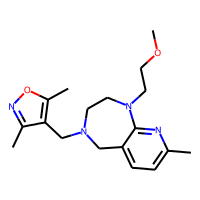
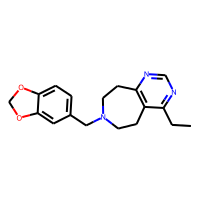
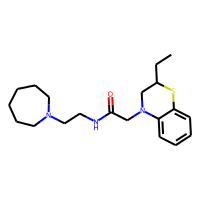
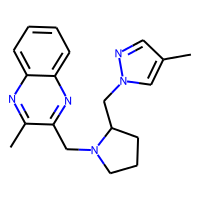

In [ ]:
from rdkit.Chem import PandasTools # for pandas dataframe with rdkit

# using pandastools to create molecule from smiles within the dataframe
PandasTools.AddMoleculeColumnToFrame(sxl,smilesCol="Smiles")
sxl.head()

def get_input(mol):
  fp = GetMorganFingerprintAsBitVect(mol, 5, nBits=500) # gets the vector
  arr = np.zeros((0,))
  ConvertToNumpyArray(fp,arr)  # converts the vector to numpy array
  return arr

sxl["Input"] = sxl["ROMol"].apply(get_input) # adding the input column to the dataframe
sxl["Target"] = np.where(sxl["S_Hit"]== "Yes", 1,0)
sxl["Target"].value_counts()
sxl

In [ ]:
from rdkit import Chem # A core definition
from rdkit.Chem.Draw import MolsToGridImage # For displaying multiple molecules
from rdkit.Chem.AllChem import * # conformer generation and adding H
from rdkit.Chem.rdMolDescriptors import * # To calculate descriptors
from rdkit.Chem.Draw import IPythonConsole # This displays the molecule in-line
from rdkit.Chem import PandasTools # for pandas dataframe with rdkit
from rdkit.DataStructs.cDataStructs import ConvertToNumpyArray
import pandas.io.formats.style
mfp= []
mfp = sxl["ROMol"].apply(get_input) # adding the input column to the dataframe
mfp_list = mfp.tolist()
mfpdf= pd.DataFrame(mfp_list)
df = pd.DataFrame(mfpdf)
df

In [ ]:
from sklearn.model_selection import train_test_split
Xt_train, Xt_test, Yt_train, Yt_test = train_test_split(df, sxl["Target"],test_size=0.2, random_state=42)

## Hyperparameter tuning


---



---



In [ ]:
kernels = ['Polynomial', 'RBF', 'Sigmoid','Linear']#A function which returns the corresponding SVC model
def getClassifier(ktype):
    if ktype == 0:
        # Polynomial kernal
        return SVC(kernel='poly', degree=8, gamma="auto",class_weight='balanced', probability=True)
    elif ktype == 1:
        # Radial Basis Function kernal
        return SVC(kernel='rbf', gamma="auto", class_weight='balanced', probability=True)
    elif ktype == 2:
        # Sigmoid kernal
        return SVC(kernel='sigmoid', gamma="auto", class_weight='balanced', probability=True)
    elif ktype == 3:
        # Linear kernal
        return SVC(kernel='linear', gamma="auto", class_weight='balanced', probability=True)

In [ ]:
## https://www.vebuso.com/2020/03/svm-hyperparameter-tuning-using-gridsearchcv/
import pandas as pd
import numpy as np
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import recall_score, precision_recall_curve,precision_score, confusion_matrix, accuracy_score, f1_score, roc_auc_score
import matplotlib.pyplot as plt
%matplotlib inline

for i in range(4):
    # Separate data into test and training sets
    X_train, X_test, y_train, y_test = train_test_split(df, sxl["Target"],test_size=0.2, random_state=42)# Train a SVC model using different kernal
    svclassifier = getClassifier(i)
    svclassifier.fit(X_train, y_train)# Make prediction
    y_pred = svclassifier.predict(X_test)# Evaluate our model
    print("Evaluation:", kernels[i], "kernel")
    print(classification_report(y_test,y_pred))

Evaluation: Polynomial kernel
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      1788
           1       0.10      1.00      0.18       191

    accuracy                           0.10      1979
   macro avg       0.05      0.50      0.09      1979
weighted avg       0.01      0.10      0.02      1979



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Evaluation: RBF kernel
              precision    recall  f1-score   support

           0       0.99      0.95      0.96      1788
           1       0.63      0.87      0.73       191

    accuracy                           0.94      1979
   macro avg       0.81      0.91      0.85      1979
weighted avg       0.95      0.94      0.94      1979

Evaluation: Sigmoid kernel
              precision    recall  f1-score   support

           0       0.99      0.94      0.96      1788
           1       0.61      0.87      0.72       191

    accuracy                           0.93      1979
   macro avg       0.80      0.91      0.84      1979
weighted avg       0.95      0.93      0.94      1979

Evaluation: Linear kernel
              precision    recall  f1-score   support

           0       0.98      0.94      0.96      1788
           1       0.61      0.82      0.70       191

    accuracy                           0.93      1979
   macro avg       0.79      0.88      0.83      197

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold

# defining parameter range
param_grid = {'C': [0.1, 1, 10, 100, 1000],
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
              'kernel': ['rbf']}

grid = GridSearchCV(SVC(class_weight='balanced', probability=True), param_grid,cv=KFold(n_splits=10), refit = True, verbose = 3)

# fitting the model for grid search
grid.fit(Xt_train, Yt_train)

Fitting 10 folds for each of 25 candidates, totalling 250 fits
[CV 1/10] END .......C=0.1, gamma=1, kernel=rbf;, score=0.889 total time= 2.2min
[CV 2/10] END .......C=0.1, gamma=1, kernel=rbf;, score=0.909 total time= 2.5min
[CV 3/10] END .......C=0.1, gamma=1, kernel=rbf;, score=0.891 total time= 2.4min
[CV 4/10] END .......C=0.1, gamma=1, kernel=rbf;, score=0.909 total time= 2.4min
[CV 5/10] END .......C=0.1, gamma=1, kernel=rbf;, score=0.906 total time= 2.3min
[CV 6/10] END .......C=0.1, gamma=1, kernel=rbf;, score=0.929 total time= 2.3min
[CV 7/10] END .......C=0.1, gamma=1, kernel=rbf;, score=0.925 total time= 2.3min
[CV 8/10] END .......C=0.1, gamma=1, kernel=rbf;, score=0.912 total time= 2.3min
[CV 9/10] END .......C=0.1, gamma=1, kernel=rbf;, score=0.904 total time= 2.4min
[CV 10/10] END ......C=0.1, gamma=1, kernel=rbf;, score=0.915 total time= 2.4min
[CV 1/10] END .....C=0.1, gamma=0.1, kernel=rbf;, score=0.890 total time= 2.4min
[CV 2/10] END .....C=0.1, gamma=0.1, kernel=rb

GridSearchCV(cv=KFold(n_splits=10, random_state=None, shuffle=False),
             estimator=SVC(class_weight='balanced', probability=True),
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                         'kernel': ['rbf']},
             verbose=3)


*   [CV 10/10] END .C=1000, gamma=0.001, kernel=rbf;, score=0.961 total time=  20.2s
*  [CV 10/10] END ..C=1000, gamma=0.01, kernel=rbf;, score=0.976 total time=  31.9s
*  [CV 10/10] END ...C=100, gamma=0.01, kernel=rbf;, score=0.976 total time=  30.7s
*  [CV 10/10] END ....C=10, gamma=0.01, kernel=rbf;, score=0.976 total time=  27.7s
*  [CV 10/10] END .....C=1, gamma=0.01, kernel=rbf;, score=0.977 total time=  37.5s

## Training

In [ ]:
######################################################################Penalized_SVM (https://www.analyticsvidhya.com/blog/2020/07/10-techniques-to-deal-with-class-imbalance-in-machine-learning/)

# load library
from sklearn.svm import SVC

# we can add class_weight='balanced' to add panalize mistake
svc_model = SVC(class_weight='balanced', C=10, kernel= "rbf", gamma =0.01, probability=True)

svc_model.fit(Xt_train, Yt_train)

svc_predict = svc_model.predict(Xt_test)# check performance

In [ ]:
from sklearn.metrics import recall_score, precision_recall_curve,precision_score, confusion_matrix, accuracy_score, f1_score
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(Yt_test,svc_predict)
print('Accuracy: %f' % accuracy)
recall= recall_score(Yt_test,svc_predict)
print("Recall %f" % recall)
precision= precision_score(Yt_test,svc_predict)
print("precision %f" % precision)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(Yt_test,svc_predict)
print('F1 score: %f' % f1)
cm= confusion_matrix(Yt_test,svc_predict)
from sklearn.metrics import recall_score, precision_recall_curve,precision_score, confusion_matrix, accuracy_score, f1_score, roc_auc_score
print('ROCAUC score:',roc_auc_score(Yt_test, svc_predict))
print('Accuracy score:',accuracy_score(Yt_test, svc_predict))
print('F1 score:',f1_score(Yt_test, svc_predict))
from sklearn.metrics import recall_score, precision_recall_curve,precision_score, confusion_matrix, accuracy_score, f1_score, roc_auc_score, cohen_kappa_score
# kappa
kappa = cohen_kappa_score(Yt_test, svc_predict)
print('Cohens kappa: %f' % kappa)
# ROC AUC
auc = roc_auc_score(Yt_test, svc_predict)
print('ROC AUC: %f' % auc)
# confusion matrix
matrix = confusion_matrix(Yt_test, svc_predict)
print(matrix)

Accuracy: 0.976251
Recall 0.780105
precision 0.967532
F1 score: 0.863768
ROCAUC score: 0.8886541457301146
Accuracy score: 0.9762506316321374
F1 score: 0.863768115942029
Cohens kappa: 0.850923
ROC AUC: 0.888654
[[1783    5]
 [  42  149]]


In [ ]:
svc_model

SVC(C=10, class_weight='balanced', gamma=0.01, probability=True)

In [ ]:
from joblib import Parallel, delayed
import joblib


# Save the model as a pickle in a file
joblib.dump(svc_model, 'sexualsSVCFinalHPT_UMFP_model5005.pkl')

# Load the model from the file
loaded_model = joblib.load('sexualsSVCFinalHPT_UMFP_model5005.pkl')


## Creating Unbalanced dual active test set

In [ ]:
import pandas as pd
sxl= pd.read_csv("M_sexual_LibrariesC_hits_nd_2ndclst_nhits.csv")
sxl['S_Hit'] = sxl['S_Hit'].replace(np.nan, "No")
sxl = sxl.iloc[: , 1:]
print(sxl['S_Hit'].value_counts())
sxl

In [ ]:
sxl["Target"] = np.where(sxl["S_Hit"]== "Yes", 1,0)
sxl["Target"].value_counts()

0    8975
1     916
Name: Target, dtype: int64

,Smiles,S_Hit,Target,ROMol,Input
0,NC(=O)c1cccc2nc([C@H]3CCN(Cc4ccccn4)C3)[nH]c12,Yes,1,,"[1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
1,Fc1ccc2[nH]c(C3CCCN3Cc3c[nH]cn3)nc2c1,Yes,1,,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
2,COc1c(C)cnc(CN(C)C2CCCCC2)c1C,Yes,1,,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ..."
3,Cc1cccc(CN2CCCC2c2cccc(Nc3nccs3)n2)c1,Yes,1,,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ..."
4,CCSCCNc1nc(-c2ccccn2)nc2c1c(C)nn2C,Yes,1,,"[1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ..."
...,...,...,...,...,...
9886,Cc1nc(C)n(C2CCCN(C(=O)c3ncoc3C(C)C)C2)n1,No,0,,"[0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, ..."
9887,COCCN1CCN(Cc2c(C)noc2C)Cc2ccc(C)nc21,No,0,,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ..."
9888,CCc1ncnc2c1CCN(Cc1ccc3c(c1)OCO3)CC2,No,0,,"[1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ..."
9889,CCC1CN(CC(=O)NCCN2CCCCCC2)c2ccccc2S1,No,0,,"[0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, ..."

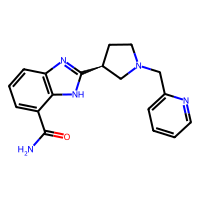
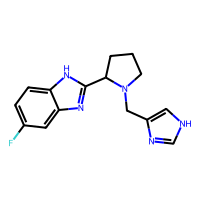
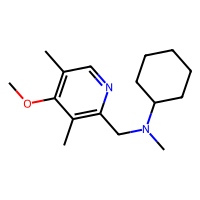
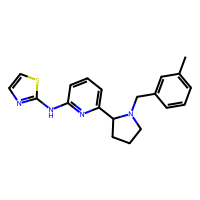
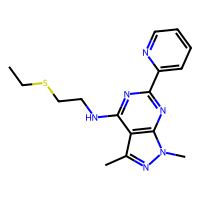
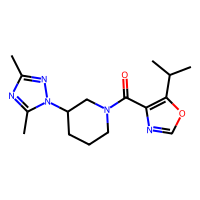
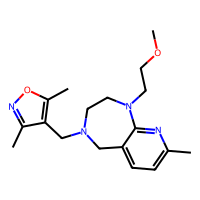
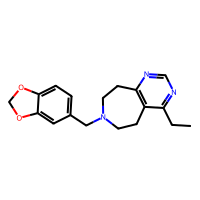
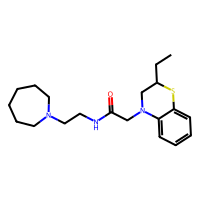
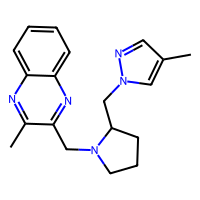

In [ ]:
from rdkit.Chem import PandasTools # for pandas dataframe with rdkit

# using pandastools to create molecule from smiles within the dataframe
PandasTools.AddMoleculeColumnToFrame(sxl,smilesCol="Smiles")
sxl.head()

def get_input(mol):
  fp = GetMorganFingerprintAsBitVect(mol, 5, nBits=500) # gets the vector
  arr = np.zeros((0,))
  ConvertToNumpyArray(fp,arr)  # converts the vector to numpy array
  return arr

sxl["Input"] = sxl["ROMol"].apply(get_input) # adding the input column to the dataframe
sxl["Target"] = np.where(sxl["S_Hit"]== "Yes", 1,0)
sxl["Target"].value_counts()
sxl

In [ ]:
mfp= []
mfp = sxl["ROMol"].apply(get_input) # adding the input column to the dataframe
print(type(mfp))
mfp

<class 'pandas.core.series.Series'>


0       [1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
1       [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
2       [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
3       [0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...
4       [1.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...
                              ...                        
9886    [0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, 0.0, ...
9887    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...
9888    [1.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, ...
9889    [0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 1.0, 0.0, 0.0, ...
9890    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, ...
Name: ROMol, Length: 9891, dtype: object

In [ ]:
mfp_list = mfp.tolist()
mfpdf= pd.DataFrame(mfp_list)
print(type(mfpdf))
mfpdf

<class 'pandas.core.frame.DataFrame'>


,0,1,2,3,4,5,6,7,8,9,...,490,491,492,493,494,495,496,497,498,499
0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9886,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
9887,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9888,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9889,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
#df=[]
df = pd.DataFrame(mfpdf)
df["Smiles"]= sxl["Smiles"]
df

,0,1,2,3,4,5,6,7,8,9,...,491,492,493,494,495,496,497,498,499,Smiles
0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,NC(=O)c1cccc2nc([C@H]3CCN(Cc4ccccn4)C3)[nH]c12
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,Fc1ccc2[nH]c(C3CCCN3Cc3c[nH]cn3)nc2c1
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,COc1c(C)cnc(CN(C)C2CCCCC2)c1C
3,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Cc1cccc(CN2CCCC2c2cccc(Nc3nccs3)n2)c1
4,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,CCSCCNc1nc(-c2ccccn2)nc2c1c(C)nn2C
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9886,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,Cc1nc(C)n(C2CCCN(C(=O)c3ncoc3C(C)C)C2)n1
9887,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,COCCN1CCN(Cc2c(C)noc2C)Cc2ccc(C)nc21
9888,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,CCc1ncnc2c1CCN(Cc1ccc3c(c1)OCO3)CC2
9889,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,CCC1CN(CC(=O)NCCN2CCCCCC2)c2ccccc2S1


In [ ]:
from sklearn.model_selection import train_test_split
Xt_train1, Xt_test1, Yt_train1, Yt_test1 = train_test_split(df, sxl["Target"],test_size=0.2, random_state=42)

## Unbalanced test set

In [ ]:
##Select those not in train set
sxl= pd.read_csv("Merged_sexual_libraries_hits and nonhits_nd.csv")
print(sxl["S_Hit"].count())
nht= sxl[sxl["S_Hit"]== "No"]
nhts= nht[["Smiles", "S_Hit"]]
nhts = nhts.reset_index(drop=True)
nhts

/content
69011


,Smiles,S_Hit
0,Cc1cnn(CC2CCCCN2Cc2nnsc2Cl)c1,No
1,CC(=O)N1CC[C@H]2CC(=O)N(C3CCCCC3)CC[C@H]2C1,No
2,Cc1cc(=O)[nH]c(=O)n1-c1cccc(Cl)c1Cl,No
3,COC(=O)c1ccccc1S(=O)(=O)NC(=O)c1cccc2c1OCCO2,No
4,Cc1noc(C2CCCN(C(=O)c3ccc(N(C)C)nc3)C2)n1,No
...,...,...
68796,CC(=O)Nc1nnc(SCc2c(C)cc(cc2C)C(C)(C)C)s1,No
68797,Cc1ccc(cc1)S(=O)(=O)c2c(COC(=O)c3cccc(C)c3)c(n...,No
68798,COc1ccc(OC)c(c1)C2C3=C(CC(C)(C)CC3=O)N(C4=C2C(...,No
68799,Cc1cc(C=C2SC(=Nc3ccccc3)N(C4CCCC4)C2=O)c(C)n1c...,No


In [ ]:
############################################Sexual data
import pandas as pd
sxl1= pd.read_csv("M_sexual_LibrariesC_hits_nd_2ndclst_nhits.csv")
sxl1['S_Hit'] = sxl1['S_Hit'].replace(np.nan, "No")
sxl1 = sxl1.iloc[: , 1:]
print(sxl1['S_Hit'].value_counts())
sxl1
ht= sxl1[sxl1["S_Hit"]== "Yes"]
ht = ht.reset_index(drop=True)
ht


/content/drive/MyDrive/PhD/PTS_datasets
No     8975
Yes     916
Name: S_Hit, dtype: int64


,Smiles,S_Hit
0,NC(=O)c1cccc2nc([C@H]3CCN(Cc4ccccn4)C3)[nH]c12,Yes
1,Fc1ccc2[nH]c(C3CCCN3Cc3c[nH]cn3)nc2c1,Yes
2,COc1c(C)cnc(CN(C)C2CCCCC2)c1C,Yes
3,Cc1cccc(CN2CCCC2c2cccc(Nc3nccs3)n2)c1,Yes
4,CCSCCNc1nc(-c2ccccn2)nc2c1c(C)nn2C,Yes
...,...,...
9886,Cc1nc(C)n(C2CCCN(C(=O)c3ncoc3C(C)C)C2)n1,No
9887,COCCN1CCN(Cc2c(C)noc2C)Cc2ccc(C)nc21,No
9888,CCc1ncnc2c1CCN(Cc1ccc3c(c1)OCO3)CC2,No
9889,CCC1CN(CC(=O)NCCN2CCCCCC2)c2ccccc2S1,No


In [ ]:
sxl= nhts.append(ht)
sxl = sxl.reset_index(drop=True)
df_smiles = sxl

<ipython-input-19-9d4f6c643dad>:1: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  sxl= nhts.append(ht)


,Smiles,S_Hit
0,Cc1cnn(CC2CCCCN2Cc2nnsc2Cl)c1,No
1,CC(=O)N1CC[C@H]2CC(=O)N(C3CCCCC3)CC[C@H]2C1,No
2,Cc1cc(=O)[nH]c(=O)n1-c1cccc(Cl)c1Cl,No
3,COC(=O)c1ccccc1S(=O)(=O)NC(=O)c1cccc2c1OCCO2,No
4,Cc1noc(C2CCCN(C(=O)c3ccc(N(C)C)nc3)C2)n1,No
...,...,...
69712,COc1cc2nc(N3CCC(CCCC4CCNCC4)CC3)nc(NCc3ccccn3)...,Yes
69713,Cc1ccc(Cl)c2sc(N3CCN(C(=O)c4ccc([N+](=O)[O-])o...,Yes
69714,CCCCCCCN1CC[C@@H](CCCc2ccnc3ccc(OC)cc23)[C@@H]...,Yes
69715,CN(C)CCNCc1cccc(-c2ccc3c(Nc4ccc(Oc5ccccn5)cc4)...,Yes


In [ ]:
## Compound
compounds = []

df1 = df_smiles. iloc [:176]
for _, compound_key, smiles in df1[["S_Hit", "Smiles"]].itertuples():
    compounds.append((Chem.MolFromSmiles(smiles), compound_key, smiles))

df2 = df_smiles. iloc [177:637]
for _, compound_key, smiles in df2[["S_Hit", "Smiles"]].itertuples():
    compounds.append((Chem.MolFromSmiles(smiles), compound_key, smiles))

df3 = df_smiles. iloc [638:880]
for _, compound_key, smiles in df3[["S_Hit", "Smiles"]].itertuples():
    compounds.append((Chem.MolFromSmiles(smiles), compound_key, smiles))

df4 = df_smiles. iloc [881:2160]
for _, compound_key, smiles in df4[["S_Hit", "Smiles"]].itertuples():
    compounds.append((Chem.MolFromSmiles(smiles), compound_key, smiles))

df5 = df_smiles. iloc [2161:2662]
for _, compound_key, smiles in df5[["S_Hit", "Smiles"]].itertuples():
    compounds.append((Chem.MolFromSmiles(smiles), compound_key, smiles))

df6 = df_smiles. iloc [2663:4273]
for _, compound_key, smiles in df6[["S_Hit", "Smiles"]].itertuples():
    compounds.append((Chem.MolFromSmiles(smiles), compound_key, smiles))

df7 = df_smiles. iloc [4274:8027]
for _, compound_key, smiles in df7[["S_Hit", "Smiles"]].itertuples():
    compounds.append((Chem.MolFromSmiles(smiles), compound_key, smiles))

df8 = df_smiles. iloc [8028:8749]
for _, compound_key, smiles in df8[["S_Hit", "Smiles"]].itertuples():
    compounds.append((Chem.MolFromSmiles(smiles), compound_key, smiles))

df9 = df_smiles. iloc [8750:9132]
for _, compound_key, smiles in df9[["S_Hit", "Smiles"]].itertuples():
    compounds.append((Chem.MolFromSmiles(smiles), compound_key, smiles))

df10 = df_smiles. iloc [9133:9993]
for _, compound_key, smiles in df10[["S_Hit", "Smiles"]].itertuples():
    compounds.append((Chem.MolFromSmiles(smiles), compound_key, smiles))

df11 = df_smiles. iloc [9994:15541]
for _, compound_key, smiles in df11[["S_Hit", "Smiles"]].itertuples():
    compounds.append((Chem.MolFromSmiles(smiles), compound_key, smiles))

df12 = df_smiles. iloc [15544:17608]
for _, compound_key, smiles in df12[["S_Hit", "Smiles"]].itertuples():
    compounds.append((Chem.MolFromSmiles(smiles), compound_key, smiles))

df13 = df_smiles. iloc [17609:18039]
for _, compound_key, smiles in df13[["S_Hit", "Smiles"]].itertuples():
    compounds.append((Chem.MolFromSmiles(smiles), compound_key, smiles))

df14 = df_smiles. iloc [18040:19840]
for _, compound_key, smiles in df14[["S_Hit", "Smiles"]].itertuples():
    compounds.append((Chem.MolFromSmiles(smiles), compound_key, smiles))

df15 = df_smiles. iloc [19841:21008]
for _, compound_key, smiles in df15[["S_Hit", "Smiles"]].itertuples():
    compounds.append((Chem.MolFromSmiles(smiles), compound_key, smiles))

df16 = df_smiles. iloc [21009:23464]
for _, compound_key, smiles in df16[["S_Hit", "Smiles"]].itertuples():
    compounds.append((Chem.MolFromSmiles(smiles), compound_key, smiles))

df17 = df_smiles. iloc [23465:24399]
for _, compound_key, smiles in df17[["S_Hit", "Smiles"]].itertuples():
    compounds.append((Chem.MolFromSmiles(smiles), compound_key, smiles))

df18 = df_smiles. iloc [24400:24499]
for _, compound_key, smiles in df18[["S_Hit", "Smiles"]].itertuples():
    compounds.append((Chem.MolFromSmiles(smiles), compound_key, smiles))

df19 = df_smiles. iloc [24500:27475]
for _, compound_key, smiles in df19[["S_Hit", "Smiles"]].itertuples():
    compounds.append((Chem.MolFromSmiles(smiles), compound_key, smiles))

df20 = df_smiles. iloc [27476:29517]
for _, compound_key, smiles in df20[["S_Hit", "Smiles"]].itertuples():
    compounds.append((Chem.MolFromSmiles(smiles), compound_key, smiles))

df21 = df_smiles. iloc [29518:32330]
for _, compound_key, smiles in df21[["S_Hit", "Smiles"]].itertuples():
    compounds.append((Chem.MolFromSmiles(smiles), compound_key, smiles))

df22 = df_smiles. iloc [32331:34028]
for _, compound_key, smiles in df22[["S_Hit", "Smiles"]].itertuples():
    compounds.append((Chem.MolFromSmiles(smiles), compound_key, smiles))
df23 = df_smiles. iloc [34029:36109]
for _, compound_key, smiles in df23[["S_Hit", "Smiles"]].itertuples():
    compounds.append((Chem.MolFromSmiles(smiles), compound_key, smiles))

df24 = df_smiles. iloc [36110:39916]
for _, compound_key, smiles in df24[["S_Hit", "Smiles"]].itertuples():
    compounds.append((Chem.MolFromSmiles(smiles), compound_key, smiles))

df25 = df_smiles. iloc [39917:40726]
for _, compound_key, smiles in df25[["S_Hit", "Smiles"]].itertuples():
    compounds.append((Chem.MolFromSmiles(smiles), compound_key, smiles))


df26 = df_smiles. iloc [40727:42620]
for _, compound_key, smiles in df26[["S_Hit", "Smiles"]].itertuples():
    compounds.append((Chem.MolFromSmiles(smiles), compound_key, smiles))

df27 = df_smiles. iloc [42624:42974]
for _, compound_key, smiles in df27[["S_Hit", "Smiles"]].itertuples():
    compounds.append((Chem.MolFromSmiles(smiles), compound_key, smiles))

df28 = df_smiles. iloc [42975:45122]
for _, compound_key, smiles in df28[["S_Hit", "Smiles"]].itertuples():
    compounds.append((Chem.MolFromSmiles(smiles), compound_key, smiles))


df29 = df_smiles. iloc [45123:45283]
for _, compound_key, smiles in df29[["S_Hit", "Smiles"]].itertuples():
    compounds.append((Chem.MolFromSmiles(smiles), compound_key, smiles))

df30 = df_smiles. iloc [45284:46911]
for _, compound_key, smiles in df30[["S_Hit", "Smiles"]].itertuples():
    compounds.append((Chem.MolFromSmiles(smiles), compound_key, smiles))

df31 = df_smiles. iloc [46912:49127]
for _, compound_key, smiles in df31[["S_Hit", "Smiles"]].itertuples():
    compounds.append((Chem.MolFromSmiles(smiles), compound_key, smiles))

df32 = df_smiles. iloc [49128:50625]
for _, compound_key, smiles in df32[["S_Hit", "Smiles"]].itertuples():
    compounds.append((Chem.MolFromSmiles(smiles), compound_key, smiles))

df33 = df_smiles. iloc [50626:51114]
for _, compound_key, smiles in df33[["S_Hit", "Smiles"]].itertuples():
    compounds.append((Chem.MolFromSmiles(smiles), compound_key, smiles))

df34 = df_smiles. iloc [51115:53592]
for _, compound_key, smiles in df34[["S_Hit", "Smiles"]].itertuples():
    compounds.append((Chem.MolFromSmiles(smiles), compound_key, smiles))

df35 = df_smiles. iloc [53593:54321]
for _, compound_key, smiles in df35[["S_Hit", "Smiles"]].itertuples():
    compounds.append((Chem.MolFromSmiles(smiles), compound_key, smiles))

df36 = df_smiles. iloc [54322:54557]
for _, compound_key, smiles in df36[["S_Hit", "Smiles"]].itertuples():
    compounds.append((Chem.MolFromSmiles(smiles), compound_key, smiles))

df37 = df_smiles. iloc [54558:55534]
for _, compound_key, smiles in df37[["S_Hit", "Smiles"]].itertuples():
    compounds.append((Chem.MolFromSmiles(smiles), compound_key, smiles))

df38 = df_smiles. iloc [55536:55615]
for _, compound_key, smiles in df38[["S_Hit", "Smiles"]].itertuples():
    compounds.append((Chem.MolFromSmiles(smiles), compound_key, smiles))

df39 = df_smiles. iloc [55617:59191]
for _, compound_key, smiles in df39[["S_Hit", "Smiles"]].itertuples():
    compounds.append((Chem.MolFromSmiles(smiles), compound_key, smiles))

df40 = df_smiles. iloc [59192:61821]
for _, compound_key, smiles in df40[["S_Hit", "Smiles"]].itertuples():
    compounds.append((Chem.MolFromSmiles(smiles), compound_key, smiles))

df41 = df_smiles. iloc [61822:62027]
for _, compound_key, smiles in df41[["S_Hit", "Smiles"]].itertuples():
    compounds.append((Chem.MolFromSmiles(smiles), compound_key, smiles))

df42 = df_smiles. iloc [62028:63298]
for _, compound_key, smiles in df42[["S_Hit", "Smiles"]].itertuples():
    compounds.append((Chem.MolFromSmiles(smiles), compound_key, smiles))

df43 = df_smiles. iloc [63299:63676]
for _, compound_key, smiles in df43[["S_Hit", "Smiles"]].itertuples():
    compounds.append((Chem.MolFromSmiles(smiles), compound_key, smiles))

df44 = df_smiles. iloc [63677:68352]
for _, compound_key, smiles in df44[["S_Hit", "Smiles"]].itertuples():
    compounds.append((Chem.MolFromSmiles(smiles), compound_key, smiles))

df45 = df_smiles. iloc [68353:]
for _, compound_key, smiles in df45[["S_Hit", "Smiles"]].itertuples():
    compounds.append((Chem.MolFromSmiles(smiles), compound_key, smiles))


In [ ]:
compounds
dff= pd.DataFrame (compounds, columns = ['mol', 'S_Hit', "Smiles"])
sxl=dff
sxl

,mol,S_Hit,Smiles
0,<rdkit.Chem.rdchem.Mol object at 0x7fc3b4541a10>,No,Cc1cnn(CC2CCCCN2Cc2nnsc2Cl)c1
1,<rdkit.Chem.rdchem.Mol object at 0x7fc3b45415b0>,No,CC(=O)N1CC[C@H]2CC(=O)N(C3CCCCC3)CC[C@H]2C1
2,<rdkit.Chem.rdchem.Mol object at 0x7fc3b4541540>,No,Cc1cc(=O)[nH]c(=O)n1-c1cccc(Cl)c1Cl
3,<rdkit.Chem.rdchem.Mol object at 0x7fc3b45413f0>,No,COC(=O)c1ccccc1S(=O)(=O)NC(=O)c1cccc2c1OCCO2
4,<rdkit.Chem.rdchem.Mol object at 0x7fc3b45412a0>,No,Cc1noc(C2CCCN(C(=O)c3ccc(N(C)C)nc3)C2)n1
...,...,...,...
69661,<rdkit.Chem.rdchem.Mol object at 0x7fc3b34cfae0>,Yes,COc1cc2nc(N3CCC(CCCC4CCNCC4)CC3)nc(NCc3ccccn3)...
69662,<rdkit.Chem.rdchem.Mol object at 0x7fc3b34cfb50>,Yes,Cc1ccc(Cl)c2sc(N3CCN(C(=O)c4ccc([N+](=O)[O-])o...
69663,<rdkit.Chem.rdchem.Mol object at 0x7fc3b34cfbc0>,Yes,CCCCCCCN1CC[C@@H](CCCc2ccnc3ccc(OC)cc23)[C@@H]...
69664,<rdkit.Chem.rdchem.Mol object at 0x7fc3b34cfc30>,Yes,CN(C)CCNCc1cccc(-c2ccc3c(Nc4ccc(Oc5ccccn5)cc4)...


In [ ]:
df3 = sxl.loc[~sxl['Smiles'].isin(Xt_train1['Smiles'])].copy()
# shuffle the DataFrame rows
df3 = df3.sample(frac = 1)
sxl=df3
sxl

,mol,S_Hit,Smiles
33991,<rdkit.Chem.rdchem.Mol object at 0x7fc3b3dc21f0>,No,CC(C)Oc1cccc2c1c(NC(=O)CN(C)C)nn2CC(F)(F)F
68769,<rdkit.Chem.rdchem.Mol object at 0x7fc3b34a7140>,Yes,CCc1c(-c2ccccc2)nc2c(c(C)c(C)n2CCN(C)C)c1N
29581,<rdkit.Chem.rdchem.Mol object at 0x7fc3b3efc6d0>,No,Cc1cc(CN(CCCO)c2ccccc2)on1
13351,<rdkit.Chem.rdchem.Mol object at 0x7fc3b422bed0>,No,CCCc1noc(-c2cn(CC(=O)N(CC)CC)nn2)n1
15429,<rdkit.Chem.rdchem.Mol object at 0x7fc3b4089460>,No,O=C(c1ccccn1)N1CCN(c2cnnc(N3CCCC3)c2)CC1
...,...,...,...
64363,<rdkit.Chem.rdchem.Mol object at 0x7fc3b35e57e0>,No,N#Cc1ccc(C(=O)N(Cc2ccncc2)C2CC2)cc1
41138,<rdkit.Chem.rdchem.Mol object at 0x7fc3b3ae3ae0>,No,CC1(C(N)=O)CN(CC2CCOCC2)CCO1
62527,<rdkit.Chem.rdchem.Mol object at 0x7fc3b3596ab0>,No,N#Cc1ccc(NCCNc2ccc(C(F)(F)F)cn2)nc1
58523,<rdkit.Chem.rdchem.Mol object at 0x7fc3b36e00b0>,No,Cc1noc(CN(C)C(=O)CCn2cnc3ccccc32)n1


In [ ]:
from rdkit.Chem import PandasTools # for pandas dataframe with rdkit

# using pandastools to create molecule from smiles within the dataframe
#PandasTools.AddMoleculeColumnToFrame(sxl,smilesCol="Smiles")
#sxl.head()

def get_input(mol):
  fp = GetMorganFingerprintAsBitVect(mol, 5, nBits=500) # gets the vector
  arr = np.zeros((0,))
  ConvertToNumpyArray(fp,arr)  # converts the vector to numpy array
  return arr

sxl["Input"] = sxl["mol"].apply(get_input) # adding the input column to the dataframe
sxl["Target"] = np.where(sxl["S_Hit"]== "Yes", 1,0)
sxl["Target"].value_counts()
sxl

,mol,S_Hit,Smiles,Input,Target
33991,<rdkit.Chem.rdchem.Mol object at 0x7fc3b3dc21f0>,No,CC(C)Oc1cccc2c1c(NC(=O)CN(C)C)nn2CC(F)(F)F,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, ...",0
68769,<rdkit.Chem.rdchem.Mol object at 0x7fc3b34a7140>,Yes,CCc1c(-c2ccccc2)nc2c(c(C)c(C)n2CCN(C)C)c1N,"[0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",1
29581,<rdkit.Chem.rdchem.Mol object at 0x7fc3b3efc6d0>,No,Cc1cc(CN(CCCO)c2ccccc2)on1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0
13351,<rdkit.Chem.rdchem.Mol object at 0x7fc3b422bed0>,No,CCCc1noc(-c2cn(CC(=O)N(CC)CC)nn2)n1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, ...",0
15429,<rdkit.Chem.rdchem.Mol object at 0x7fc3b4089460>,No,O=C(c1ccccn1)N1CCN(c2cnnc(N3CCCC3)c2)CC1,"[0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0
...,...,...,...,...,...
64363,<rdkit.Chem.rdchem.Mol object at 0x7fc3b35e57e0>,No,N#Cc1ccc(C(=O)N(Cc2ccncc2)C2CC2)cc1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, ...",0
41138,<rdkit.Chem.rdchem.Mol object at 0x7fc3b3ae3ae0>,No,CC1(C(N)=O)CN(CC2CCOCC2)CCO1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 1.0, ...",0
62527,<rdkit.Chem.rdchem.Mol object at 0x7fc3b3596ab0>,No,N#Cc1ccc(NCCNc2ccc(C(F)(F)F)cn2)nc1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0
58523,<rdkit.Chem.rdchem.Mol object at 0x7fc3b36e00b0>,No,Cc1noc(CN(C)C(=O)CCn2cnc3ccccc32)n1,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...",0


In [ ]:
from rdkit import Chem # A core definition
from rdkit.Chem.Draw import MolsToGridImage # For displaying multiple molecules
from rdkit.Chem.AllChem import * # conformer generation and adding H
from rdkit.Chem.rdMolDescriptors import * # To calculate descriptors
from rdkit.Chem.Draw import IPythonConsole # This displays the molecule in-line
from rdkit.Chem import PandasTools # for pandas dataframe with rdkit
from rdkit.DataStructs.cDataStructs import ConvertToNumpyArray
import pandas.io.formats.style

In [ ]:
mfp= []
mfp = sxl["mol"].apply(get_input) # adding the input column to the dataframe
mfp_list = mfp.tolist()
mfpdf= pd.DataFrame(mfp_list)
df = pd.DataFrame(mfpdf)
df

In [ ]:
Xt_test = df
Yt_test= sxl["Target"]

#SVC

In [ ]:
import pandas
from sklearn import model_selection
import joblib

# load the model from disk
svc_model = joblib.load('/content/drive/MyDrive/PhD/Penalized_SVM_MFP/sexualsSVCFinalHPT_UMFP_model5005.pkl')
#result = loaded_model.score(Xt_test, Yt_test)
#print(result)


In [ ]:
######################################################################Penalized_SVM (https://www.analyticsvidhya.com/blog/2020/07/10-techniques-to-deal-with-class-imbalance-in-machine-learning/)

# load library
from sklearn.svm import SVC

svc_predict = svc_model.predict(Xt_test)# check performance


In [ ]:
from sklearn.metrics import recall_score, precision_recall_curve,precision_score, confusion_matrix, accuracy_score, f1_score
# accuracy: (tp + tn) / (p + n)
accuracy = accuracy_score(Yt_test,svc_predict)
print('Accuracy: %f' % accuracy)
recall= recall_score(Yt_test,svc_predict)
print("Recall %f" % recall)
precision= precision_score(Yt_test,svc_predict)
print("precision %f" % precision)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(Yt_test,svc_predict)
print('F1 score: %f' % f1)
from sklearn.metrics import recall_score, precision_recall_curve,precision_score, confusion_matrix, accuracy_score, f1_score, roc_auc_score
print('ROCAUC score:',roc_auc_score(Yt_test, svc_predict))
print('Accuracy score:',accuracy_score(Yt_test, svc_predict))
print('F1 score:',f1_score(Yt_test, svc_predict))
from sklearn.metrics import recall_score, precision_recall_curve,precision_score, confusion_matrix, accuracy_score, f1_score, roc_auc_score, cohen_kappa_score
# kappa
kappa = cohen_kappa_score(Yt_test, svc_predict)
print('Cohens kappa: %f' % kappa)
# ROC AUC
auc = roc_auc_score(Yt_test, svc_predict)
print('ROC AUC: %f' % auc)
# confusion matrix
matrix = confusion_matrix(Yt_test, svc_predict)
print(matrix)
cm= confusion_matrix(Yt_test,svc_predict)
cm

Accuracy: 0.993058
Recall 0.658120
precision 0.163830
F1 score: 0.262351
ROCAUC score: 0.8259036081725535
Accuracy score: 0.993058116232465
F1 score: 0.262350936967632
Cohens kappa: 0.260129
ROC AUC: 0.825904
[[61865   393]
 [   40    77]]


array([[61865,   393],
       [   40,    77]])

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

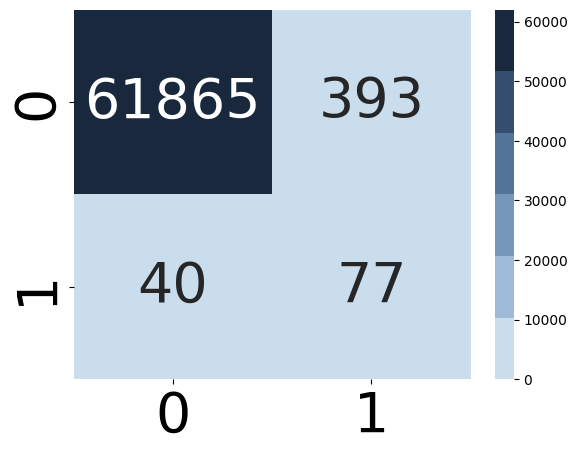

In [ ]:
import seaborn as sns
from sklearn.metrics import recall_score, precision_recall_curve,precision_score, confusion_matrix, accuracy_score, f1_score
cm=[[61865 ,  393],
 [   40 ,   77]]
fig, ax = plt.subplots()
ax.tick_params(labelsize=40)
#ax.legend(markerscale=15)
sns.heatmap(cm, cmap=sns.cubehelix_palette(start=-.19,rot=-0.05), annot=True,annot_kws={"size": 40}, fmt='d',vmin=0, vmax=62000)# font size
plt.savefig('Dual_SVC_UB_testMat.png',dpi=300, bbox_inches='tight')
from google.colab import files
files.download("Dual_SVC_UB_testMat.png")

In [ ]:
print(f"Test Set: {len(Xt_test)}")
print(Yt_test.value_counts())
print(matrix)

Test Set: 62375
0    62258
1      117
Name: Target, dtype: int64
[[61865   393]
 [   40    77]]
